# Luescher 3D

In this notebook the discretization effects of the phase shifts are analyzed using a contact interaction in a finite volume.

## Intro

In 3-Dimensions, the continuum infinite volume effective range expansion is given by
$$
    p \cot(\delta(p)) = - \frac{1}{a_0} + r_e p^2 + \cdots \, ,
$$
where $a_0$ is the so called scattering lenght and $r_e$ the effective range.

In case of a contact interaction, the effective range is zero and the phase shifts are described by the scattering length only.
$$
    p \cot(\delta(p)) = - \frac{1}{a_0} \, .
$$

Of particulare interest is the case of infinite scattering length -- the unitary limit in which scattering has no information about fundamental quantum parameters.

For computations in a finite volume, one can relate S-wave phase shifts to the zeta function by

$$
    p \cot(\delta(p)) = \frac{1}{\pi L} S_3(x) \, , \qquad x = \left(\frac{p L}{2 \pi }\right)^2
$$

# Init

## Import

In [1]:
# Python modules
import itertools
import os
from dataclasses import dataclass

# Data management
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pylab as plt
import seaborn as sns
sns.set(style="ticks", font_scale=.9, palette="muted")

# Fitting
import scipy.optimize as opt
from scipy.interpolate import interp1d

# Project modules
import luescher_nd.utilities as ut
import luescher_nd.zeta as zeta

In [2]:
%load_ext blackcellmagic

In [3]:
ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DATA = os.path.join(ROOT, "data")

In [4]:
@dataclass
class LinFunc:
    """Class which simplifies fitting of linear functions
    
    f(x) = m * x + b
    """
    x: np.ndarray
    y: np.ndarray
        
    def chi2(self, mb):
        """Compute chi**2 for f(x) and input data.
        """
        return np.sum((mb[0]*self.x + mb[1] - self.y)**2)

## Setting up the zeta function

The zeta function is defined by

$$ 
S_3(x, \Lambda) = \sum_{\vec n \in \mathbb{Z}_\Lambda^3}  \frac{1}{\vec n ^2 - x} - \frac{2 \Lambda}{\pi} \,,\qquad
\mathbb{Z}_\Lambda^3 = \left\{ \vec n \in \mathbb{Z}^3 \middle\vert | n_i | \leq \Lambda  \right\}
$$

And we are interested in results for $\Lambda \to \infty$ (RIGHT?!).

Because I only have values of the zeta functions at specific points, I have coded up interpolators for this function. Obviously interpolation works best if you are not close to the divergencies (defined by $x = \vec n$ for $\vec n \in \mathbb{Z}_\Lambda^3$).
Thus I piecewise encode interpolation between each divergencies. 

In [5]:
S3 = pd.read_csv(os.path.join(DATA, "S3.dat"), sep="\s+", header=None, names=["x", "y"])

Locate divergencies

In [6]:
divergencies = [-100]
for x, y, z in itertools.product(*[list(range(5))]*3):
    divergencies.append(x**2 + y**2 + z**2)
divergencies = np.unique(divergencies)

Code up piecewise interpolators and locate zeros

In [7]:
zeros = []
interpolators = {}
for start, end in zip(divergencies[:-1], divergencies[1:]):
    start += 0.001
    end -= 0.001
    
    x, y = S3[(S3.x > start) & (S3.x < end)].values.T
    
    if len(x) == 0:
        continue
    
    f = interp1d(x, y, kind="linear")
    interpolators[(start, end)] = f
    
    res = opt.minimize(
        lambda x: f(x)**2, 
        np.array([(start+end)*1./2, ]), 
        tol=1.e-12,
        bounds=((x.min()+0.001, x.max()-0.001),)
    )
    zeros.append(res.x[0])

zeros = np.array(zeros)

def S3intp(x):
    """3-D Zeta function as piecewise defined interpolators.
    
    Returns NaN if out of interpolation range.
    """
    try:
        out = [f(x) for (start, end), f in interpolators.items() if x > start and x < end]
        out = out[0] if len(out) == 1 else np.NaN      
    except ValueError as e:
        out = np.NaN
    return out

Here comes the visualization

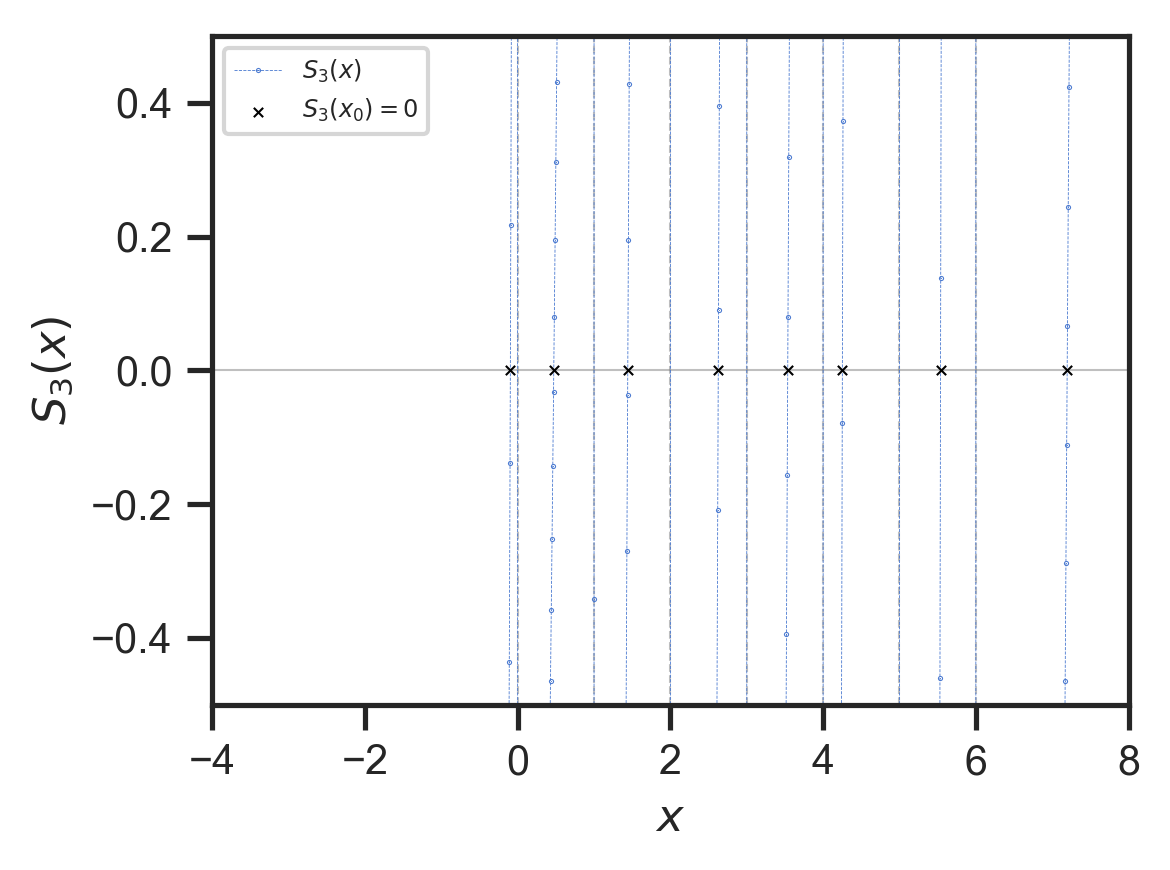

In [8]:
fig_zeta_3d, axs = plt.subplots(
    dpi=300, figsize=(4, 3), ncols=1, sharey=True, sharex=True
)

for ax in [axs]:
    ax.axhline(0, ls="-", c="grey", lw=0.5, alpha=0.5)

    for div in divergencies:
        if div < S3.x.max():
            ax.axvline(div, ls="--", c="grey", lw=0.5, alpha=0.5)

    S3.plot(ax=ax, x="x", y="y", lw=0.2, ls="--", marker=".", ms=0.5, label="$S_3(x)$")

    for zero in zeros:
        label = "$S_3(x_0) = 0$" if zero == zeros[0] else None
        if zero < S3.x.max():
            ax.scatter(
                zero, 0, marker="x", c="black", lw=0.5, s=5, zorder=10, label=label
            )

    ax.set_ylim(-0.5, 0.5)
    ax.legend(loc="best", fontsize="xx-small")

    ax.set_xlabel("$x$")
    ax.set_ylabel("$S_3(x)$")

    ax.set_xlim(S3.x.min(), S3.x.max())

plt.tight_layout()
plt.show(fig_zeta_3d)

# Fitting

I solve the finite volume discrete Schroediner equation for a contact interaction which is defined by

$$
    V(\vec n', \vec n) = \frac{c_0}{\epsilon^3} \delta_{\vec n', \vec n} \delta_{\vec n, \vec 0} \, .
$$

To obtain results at the unitary limit, I fit $c_0$ such that the lowest energy eigenstate matches the first (left most) zero of the zeta function.
This effectively renormalizes the contact interaction.
Doing so, one would assume that this procedure fixes the scattering length to infinity and the effective range expansion is flat -- meaning each box energy level corresponds to a zero of the zeta function.

The argument of the zeta function is related to the energies by
$$x_0 = \left( \frac{p_0 L}{2 \pi} \right)^2 = \frac{\mu E_0 L^2}{2\pi^2}$$

I repeat this process for different lattice spacings $\epsilon$ and different implementations of the derivative denoted by the variable $n_{\mathrm{step}}$ (e.g., $n_{\mathrm{step}} = 1$ connnects the center site with 1 other site in each direction and has corrections at the order $\epsilon^{2n_{\mathrm{step}}}$).

In [9]:
HBARC = 197.326 # MeV / fm
M_NUCLEON = (938.27 + 939.57) / 2 / HBARC # in fm^{-1}

mu = M_NUCLEON / 2
L = 1.

Load the results and mask of energies which are outside the range of interest.
For example, a state which is zero at the origin does not feel the contact interaction and is thus directly at the divergencies of the zeta function.
This energy levels are filtered out.

In [10]:
f_energies = os.path.join(DATA, "luescher-3d-res.csv")

df = pd.read_csv(f_energies)
df["L"] = df.apply(
    lambda row:row["n1d_max"] * row["epsilon"], axis=1,
)
df["x"] = df.apply(
    lambda row: row["energy"] * mu * row["L"]**2 / 2 / np.pi ** 2 ,
    axis=1,
).round(5)
mask = (df.x.round(3) * 1000).astype(int).isin(divergencies * 1000)
df_zeros = df[~mask].copy().drop_duplicates(["x","nstep", "epsilon"])
df_zeros["y"] = df.apply(lambda row: S3intp(row["x"]), axis=1)

ymax = 4

mask = df_zeros.y.abs() < ymax
df_zeros = df_zeros[mask].copy()

# Analysis

## Effective range expansion

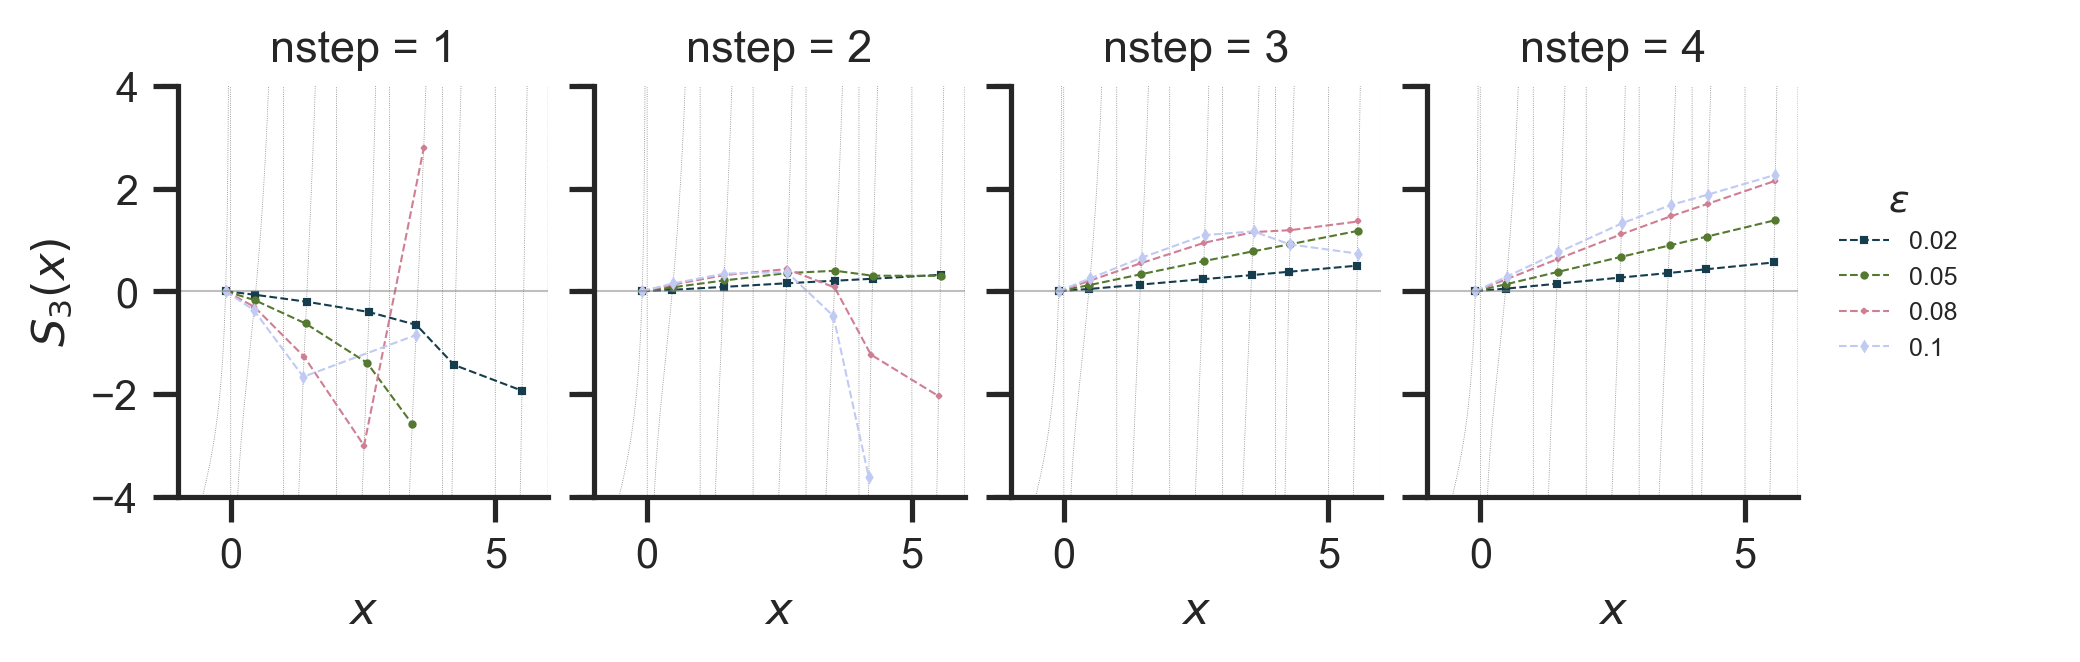

In [11]:
g = sns.FacetGrid(
    df_zeros,
    col="nstep",
    hue="epsilon",
    hue_kws={"marker": ["s", "o", "x", "d"]},
    palette="cubehelix",
    xlim=(-1, 6),
    ylim=(-ymax, ymax)
)

g.map(plt.plot, "x", "y", ms=1, lw=0.5, ls="--")

for ax in g.axes[0]:
    ax.axhline(0, ls="-", c="grey", lw=0.5, alpha=0.5)

    S3.plot(
        ax=ax,
        x="x",
        y="y",
        lw=0.2,
        ls=":",
        ms=0.5,
        c="grey",
        zorder=-1,
        legend=False,
        label="$S_3$",
    )
    ax.set_xlim(-1, 6)

g.set_xlabels("$x$")
g.set_ylabels("$S_3(x)$")

g.add_legend(title="$\epsilon$", fontsize=6, bbox_to_anchor=(1.1, 0.65))

g.fig.set_dpi(300)
g.fig.set_figheight(2)
g.fig.set_figwidth(6)

plt.show(g.fig)

Obviously, it is quite intriguing to see the linear depencence of $S_3$ in the right panel.
My first expecation was a flat line at zero.

It suggests that approximations of the derivative are close enough to the continuum but the effective range expansion is not simply given by the scattering length only.

## Fit the linear functions of the nstep = 4 plot

Let's try to describe the results by a linear function

$$ f_\epsilon(x_\epsilon) = m_\epsilon x_\epsilon + b_\epsilon \overset{!}{=} S_3(x_\epsilon)$$

In [12]:
tf = df_zeros.query("epsilon < 0.1 and nstep == 4").set_index(["epsilon", "nlevel"])


data = []
for epsilon in tf.index.get_level_values("epsilon").unique():
    x, y = tf.loc[epsilon, ["x", "y"]].values.T
    f = LinFunc(x, y)

    m, b = opt.minimize(f.chi2, (1.0, 0.0)).x

    data.append({"epsilon": epsilon, "m": m, "b": b})
    
df = pd.DataFrame(data)
df

,b,epsilon,m
0,0.062665,0.08,0.381959
1,0.023577,0.05,0.244247
2,0.007770,0.02,0.099497


### Dependence of slope (effective range) on lattice spacing

Will this slope vanish in the continuum?

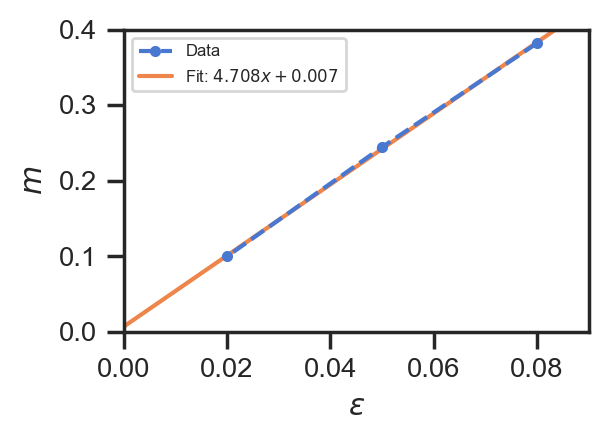

In [13]:
fig, ax = plt.subplots(figsize=(3,2), dpi=200)

df.plot("epsilon", "m", marker=".", ls="--", ax=ax, legend=False, label="Data")

func = LinFunc(df.epsilon.values, df.m.values)
m, b = opt.minimize(func.chi2, (1.0, 0.0)).x

xnew = np.linspace(0.00, 0.09)

ax.plot(xnew, xnew*m +b, zorder=-1, label=f"Fit: ${m:1.3f}x  {b:+1.3f}$")
ax.set_xlim(0.0, 0.09)
ax.set_ylim(0.0, 0.4)
ax.legend(fontsize=6)

ax.set_ylabel("$m$")
ax.set_xlabel("$\epsilon$")

plt.show(fig)

It seems so (I would argue that the numerical precision is at the percent level)

## Contact interaction strength vs lattice spacing

How does the contact interaction depend on the lattice spacing?

In the continuum and infinite volume, using a momentum cutoff regulator $\Lambda$, one finds that

$$
    c_0(\Lambda) 
    = 
    \frac{\frac{4 \pi}{\mu}}{\frac{1}{a_0} - \frac{2\Lambda}{\pi}}
    \overset{a_0 \to \infty}{\longrightarrow}
    - \frac{2 \pi^2}{\mu \Lambda}
$$

In other words, at the unitary limit, the contact interaction is inversely proportional to the cutoff.

On the finite volume lattice one finds.

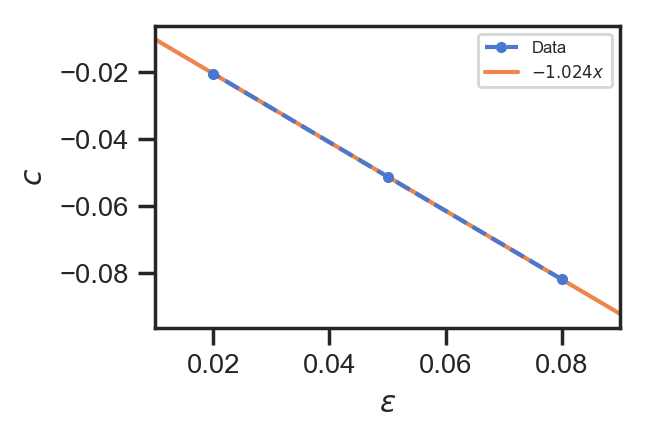

In [14]:
fig, ax = plt.subplots(figsize=(3,2), dpi=200)

tf = df_zeros.query("epsilon < 0.1 and nstep == 4").drop_duplicates(["c", "epsilon"])
tf.plot("epsilon", "c", marker=".", ls="--", ax=ax, legend=False, label="Data")

func = LinFunc(tf.epsilon.values, tf.c.values)
m, b = opt.minimize(func.chi2, (1.0, 0.0)).x

xnew = np.linspace(0.01, 0.09)

ax.plot(xnew, xnew*m +b, zorder=-1, label=f"${m:1.3f}x$")

ax.set_xlim(0.01, 0.09)
ax.set_xlabel("$\epsilon$")
ax.set_ylabel("$c$")

ax.legend(fontsize=6)

plt.show(fig)

In other words the contact interaction is directly proportional to the lattice spacing.
This works out quite nicely since one would expect the lattice spacing to be inversely proportional to a momentum cutoff.
Again confusing here is this factor of nearly exactly one!

## Conclusion

The lattice spacing in 3 dimensions introduces two effects.
In presence of a non-zero coordinate space lattice spacing:
1. One approximates the continuum derivative by a finite step derivative. I address this effect by the name **dispersion artifacts**
2. One introduces an ultra-violet regulator. I address this this effect by the name **regulator artifacts**

It seems that it is possible to remove **dispersion artifacts** by sufficiently improving the implementation of the derivative and reducing the size of the lattice spacing for still non-zero lattice spacings.

However, removing **regulator artifacts** is less trivial. 

As discussed, it seems quite likely that the presence of lattice spacing **regulator artifacts** are related to introducting an effective range term in the effective range expansion.

Can we remove this effect?

Also: I have fixed the energies such that $S_3(x_0) = 0$ to bring the set the scattering length to $\infty$.

However, if there is an effective range, one must actually fix this to $S_3(x_0) - r_e p_0^2 = - \frac{1}{a_0} = 0$, right?

In other words, choose $c_0$, compute several energies, fit the Luescher results $S_3(x_i)$ using a linear function $f(x_i)$ (is this sufficient) and compute the value of $f$ at $x = 0$.
Repeat optimze the choice of $c_0$ such that $f(x)$, which is now effectively a function of $c_0$, is zero at $x=0$.
    